## **EMOTION_BASED_MUSIC_RECOMMENDATION**


# setting up directory with pre-installed kaggle.json token

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Uploading FER2013 Dataset to directory

In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:00<00:00, 168MB/s]
100% 60.3M/60.3M [00:00<00:00, 149MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [91]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers, initializers
from tensorflow.keras.applications import VGG19,MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D,GlobalMaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [5]:
tf.__version__

'2.15.0'

In [6]:
os.makedirs('test_dir',exist_ok = True)

In [7]:
#abbreviation used: EBSR {Emotion Based Song Recommendation}
project_name = "FER_2013_EBSR"
model_names = ['VGG19_TL',"MobileNet_TL"]
base_dir = '/content/'

project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)

In [8]:
# for models in model_names:
#   model_dir = os.path.join(base_dir,models)
#   os.makedirs(model_dir,exist_ok=True)

#   print(f'project created at:{project_dir}')

project created at:/content/FER_2013_EBSR
project created at:/content/FER_2013_EBSR


In [9]:
image_exts = ['jpeg','jpg','png']
data_dir = '/content/train'

for root,dirs,files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root,file)

    try:
      file_type=imghdr.what(file_path)

      if file_type not in image_exts:
        print(f'Image not in extension list {file_path}')
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)

    except Exception as ex:
      print(f'Issue with file {file_path}. Error occurred: {ex}')
      os.remove(file_path)

In [10]:
def count_files_in_subdirs(directory,set_name):
  counts ={}

  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)

    if os.path.isdir(item_path):
      counts[item]=len(os.listdir(item_path))

  df = pd.DataFrame(counts,index=[set_name])
  return df

In [11]:
train_dir = '/content/train'
test_dir = '/content/test'

In [12]:
train_count= count_files_in_subdirs(train_dir,"train")
test_count = count_files_in_subdirs(test_dir,'test')
print(train_count)
print(test_count)

       fear  neutral   sad  disgust  angry  happy  surprise
train  4097     4965  4830      436   3995   7215      3171
      fear  neutral   sad  disgust  angry  happy  surprise
test  1024     1233  1247      111    958   1774       831


<Axes: >

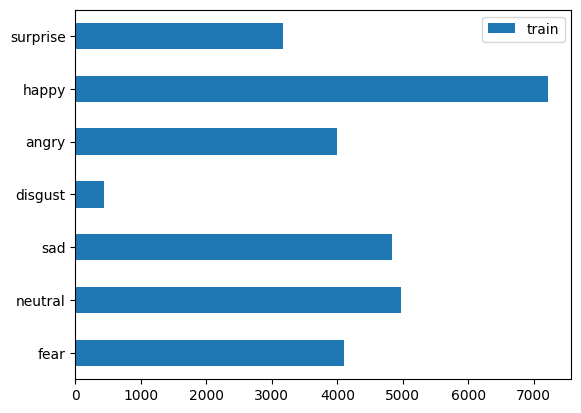

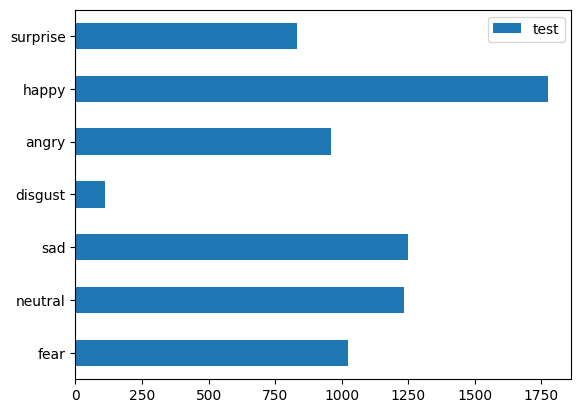

In [13]:
# plotting bargraph to represent counts of each emotions

train_count.transpose().plot(kind='barh')
test_count.transpose().plot(kind='barh')

['fear', 'neutral', 'sad', 'disgust', 'angry', 'happy', 'surprise']


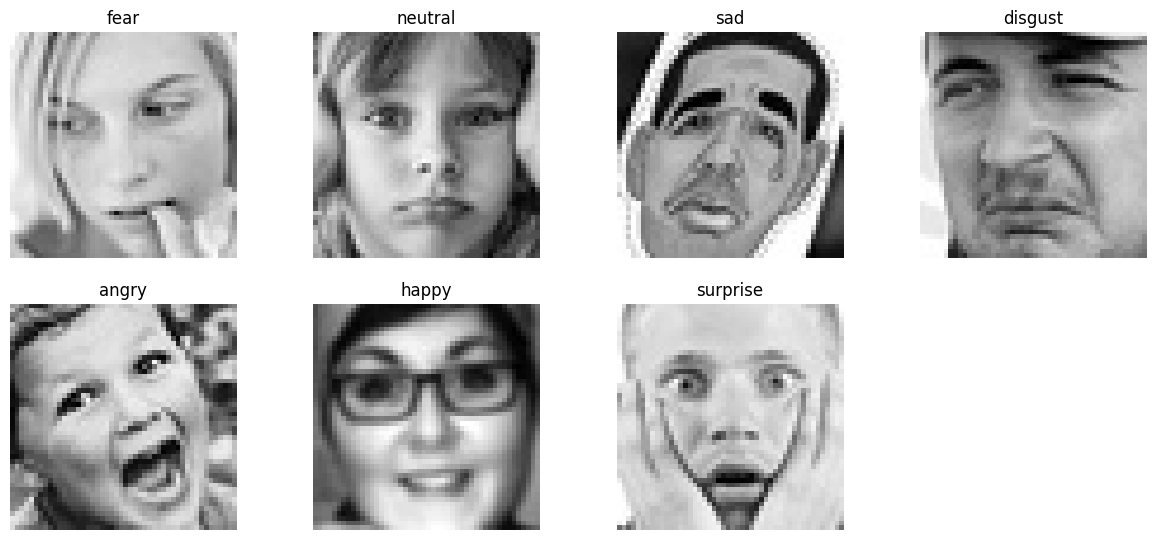

In [113]:
emotions = os.listdir(train_dir)
print(emotions)
plt.figure(figsize=(15,10))
classes=(list(enumerate(emotions,1)))
for i in range(1,8):
  folder = os.path.join(train_dir,emotions[i-1])
  img_path = os.path.join(folder,os.listdir(folder)[6])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap="gray")
  plt.title(emotions[i-1])
  plt.axis('off')
  # print(emotions)

In [55]:
print(classes)

[(1, 'fear'), (2, 'neutral'), (3, 'sad'), (4, 'disgust'), (5, 'angry'), (6, 'happy'), (7, 'surprise')]


In [112]:
image = "/content/train/angry/Training_10120469.jpg"
img = cv2.imread(image)
scaled=cv2.resize(img,(256,256))
gray=cv2.cvtColor(scaled,cv2.COLOR_BGR2GRAY)
# gray_img = cv2.imread(gray)
if img is not None:
  print('Shape of coloured image:',img.shape)
  print('Shape of scaled image:',scaled.shape)
  print('Shape of grayscaled image:',gray.shape)
else:
  print("The image couldn't be loaded. Please check the path and file permissions.")

Shape of coloured image: (48, 48, 3)
Shape of scaled image: (256, 256, 3)
Shape of grayscaled image: (256, 256)


In [66]:
train_data_dir = "/content/train"
test_data_dir = "/content/test"

img_width,img_height = 256,256
batch_size = 256
epochs = 10
num_classes = 7

data_gen = ImageDataGenerator(rescale=1/255.0,
                              rotation_range=90,
                              zoom_range=0.5,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode="nearest",
                              validation_split=0.2,
                              )
test_gen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
train_gen = data_gen.flow_from_directory(train_data_dir,target_size=(img_width,img_height),batch_size=batch_size,class_mode='categorical')
test_gen = test_gen.flow_from_directory(test_data_dir,target_size=(img_width,img_height),batch_size=batch_size,class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Custom CNN


In [114]:
cnn = Sequential()

cnn.add(Conv2D(32,kernel_size=(3,3),activation='relu',
               input_shape=(256,256,3),
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.4))

cnn.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.4))

cnn.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same',
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same',
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.4))

cnn.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.4))

cnn.add(GlobalMaxPool2D())
cnn.add(Dense(1024,activation="relu",
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.1))
cnn.add(Dense(512,activation="relu",
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(Dropout(0.1))
cnn.add(Dense(256,activation="relu",
 kernel_initializer='he_normal',
               kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4)))
cnn.add(Dense(7,activation="softmax"))

optimizer = Adam(learning_rate=0.003,beta_1=0.9,beta_2=0.999,epsilon=1e-07,ema_momentum=True,name='adam')
cnn.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [115]:
cnn.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_38 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_121 (Conv2D)         (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization_39 (Ba  (None, 256, 256, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                     

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


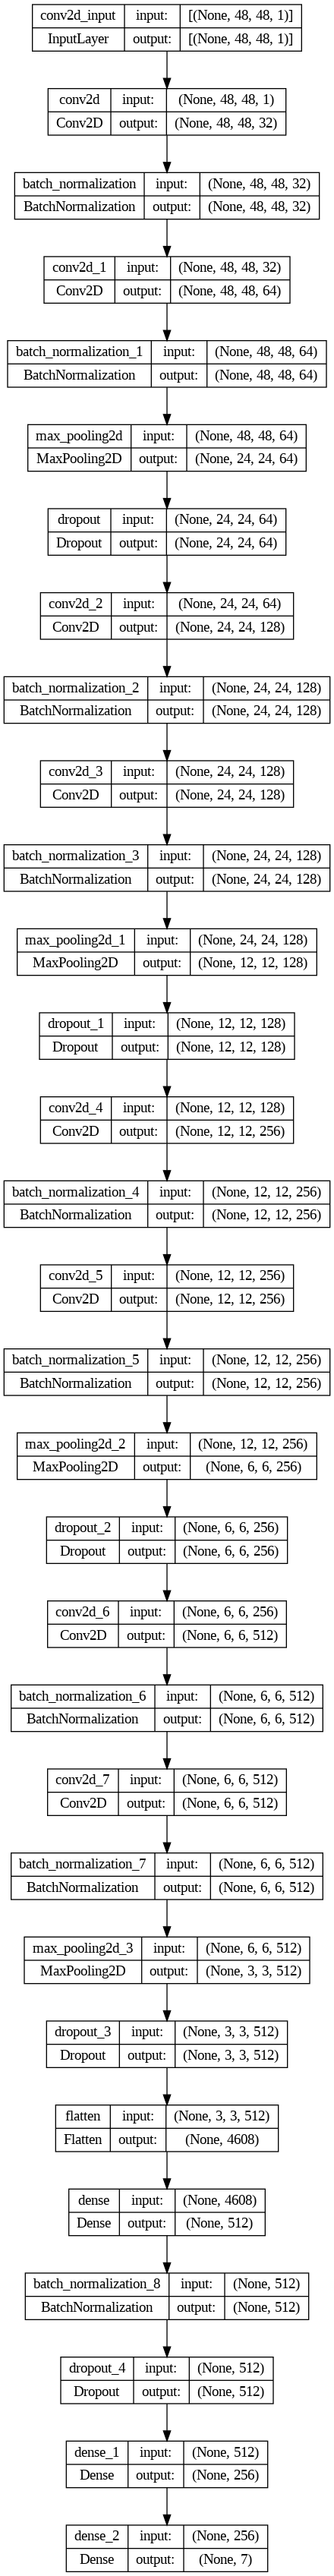

In [116]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(cnn, to_file='convnet.png', show_shapes = True, show_layer_names=True)
Image(filename="convnet.png")

In [117]:
cnn_path = '/content/FER_2013_EBSR/Custom_CNN'
name = "Custom_CNN"
chk_path=os.path.join(cnn_path,name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,mode='min',
                             monitor='val_loss')

earlystop=EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        mode='min',
                        patience=10,
                        verbose=1,
                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'),separator='|')
callbacks = [checkpoint,earlystop,reduce_lr,csv_logger]
train_steps_per_epoch = train_gen.samples // train_gen.batch_size + 1
test_steps_per_epoch = test_gen.samples // test_gen.batch_size + 1


In [ ]:
history = cnn.fit(train_gen,
                  steps_per_epoch=train_steps_per_epoch,
                  validation_data=test_gen,
                  validation_steps=test_steps_per_epoch,
                  epochs=100,
                  callbacks=callbacks,
                  shuffle=True,
                  )

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 4.3598 - accuracy: 0.2324
Epoch 1: val_loss improved from inf to 4.09262, saving model to /content/FER_2013_EBSR/Custom_CNN/Custom_CNN
113/113 [==============================] - 151s 1s/step - loss: 4.3598 - accuracy: 0.2324 - val_loss: 4.0926 - val_accuracy: 0.2304 - lr: 0.0030
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 3.8117 - accuracy: 0.2544
Epoch 2: val_loss improved from 4.09262 to 3.55680, saving model to /content/FER_2013_EBSR/Custom_CNN/Custom_CNN
113/113 [==============================] - 148s 1s/step - loss: 3.8117 - accuracy: 0.2544 - val_loss: 3.5568 - val_accuracy: 0.2459 - lr: 0.0030
Epoch 3/100
113/113 [==============================] - ETA: 0s - loss: 3.2789 - accuracy: 0.2601
Epoch 3: val_loss improved from 3.55680 to 3.08960, saving model to /content/FER_2013_EBSR/Custom_CNN/Custom_CNN
113/113 [==============================] - 148s 1s/step - loss: 3.2789 - accuracy: 0

In [ ]:
cnn.save("CNN_1.h5")
cnn.save_weights('CNN_1_weights.h5')


In [56]:
def plot_training_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

In [57]:
plot_training_history(history)

NameError: name 'history' is not defined

In [58]:
train_loss,train_acc = cnn.evaluate(train_gen,callbacks=callbacks)
test_loss,test_acc = cnn.evaluate(test_gen,callbacks=callbacks)
print('final train accuracy = {:.2f},validation accuracy = {:.2f}'.format(train_acc*100,test_acc*100))

29/29 [==============================] - 9s 302ms/step - loss: 1.8065 - accuracy: 0.2471
final train accuracy = 25.13,validation accuracy = 24.71


29/29 [==============================] - 9s 305ms/step


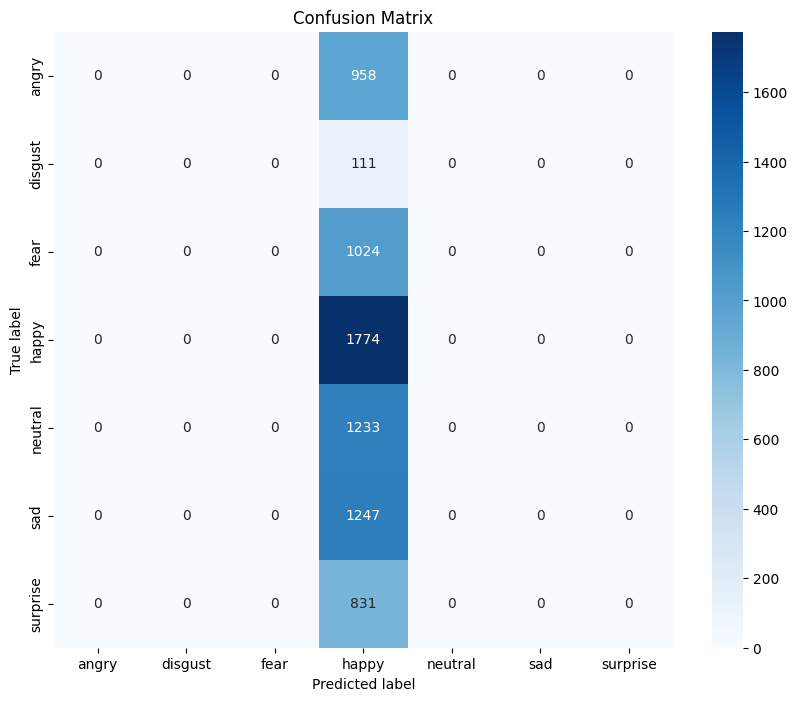

In [59]:
true_classes = test_gen.classes
# classes=['Angry','Disgust','Happy','Neutral','Fear','Surprise','Sad']
predicted_classes = np.argmax(cnn.predict(test_gen, steps=np.ceil(test_gen.samples/test_gen.batch_size)), axis=1)
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [60]:
report = classification_report(true_classes,predicted_classes,target_names=class_labels,zero_division=0)
print('Classification Report:\n',report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



# Making Predictions

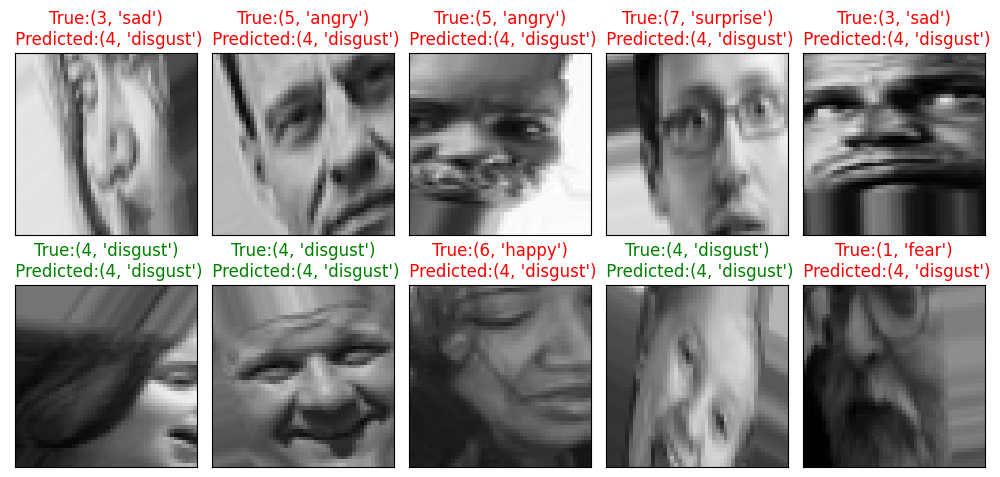

In [61]:

batch_size = test_gen.batch_size
random_batch = np.random.randint(0,len(test_gen)-1)
random_img_index = np.random.randint(0,batch_size, 10)

fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
  random_img = test_gen[random_batch][0][random_img_index[i]]
  random_img_label=np.argmax(test_gen[random_batch][1][random_img_index[i]],axis=0)

  model_pred= np.argmax(cnn.predict(tf.expand_dims(random_img,axis=0),verbose=0), axis=1)[0]
  ax.imshow(random_img.squeeze(), cmap='gray')
  color = "green" if classes[random_img_label] == classes[model_pred] else 'red'
  ax.set_title(f"True:{classes[random_img_label]}\n Predicted:{classes[model_pred]}",color=color)

plt.tight_layout()
plt.show()

In [ ]:
music_player = pd.read_csv('songs1.csv')
music_player.head()

,name,album,date,artist,popularity,mood
0,Illahi,YJHD,2013,NaN,NaN,energetic
1,Ghagra,YJHD,2013,NaN,NaN,energetic
2,Balam Pichkari,YJHD,2013,NaN,NaN,energetic
3,Kabira,YJHD,2013,NaN,NaN,sad
4,Subhanallah,YJHD,2013,NaN,NaN,happy


In [ ]:
music_player['mood'].value_counts()

mood
happy        8
energetic    6
sad          1
Name: count, dtype: int64

In [ ]:
play = music_player[music_player['mood']=='happy']
play = play[:3].reset_index(drop=True)
display(play)

,name,album,date,artist,popularity,mood
0,Subhanallah,YJHD,2013,NaN,NaN,happy
1,Koi Mil Gya,Kuch Kuch Hota Hai,1998,NaN,NaN,happy
2,Yeh Ladka Hai Deewana,Kuch Kuch Hota Hai,1998,NaN,NaN,happy


In [ ]:
def recommender(pred_class):
  if(pred_class=='Fear' or pred_class=='Angry'):
    play = music_player[music_player['mood']=='calm']
    play = play[:5].reset_index(drop=True)
    display(play)

  if(pred_class=='Sad' or pred_class=='Happy'):
    play = music_player[music_player['mood']=='happy']
    play = play[:5].reset_index(drop=True)
    display(play)

  if(pred_class=="Surprise" or pred_class=='Neutral'):
    play = music_player[music_player['mood']=='energetic']
    play = play[:5].reset_index(drop=True)
    display(play)

  if(pred_class=="Disgust"):
    play = music_player[music_player['mood']=='sad']
    play = play[:5].reset_index(drop=True)
    display(play)


In [ ]:
recommender('Sad')

,name,album,date,artist,popularity,mood
0,Subhanallah,YJHD,2013,NaN,NaN,happy
1,Koi Mil Gya,Kuch Kuch Hota Hai,1998,NaN,NaN,happy
2,Yeh Ladka Hai Deewana,Kuch Kuch Hota Hai,1998,NaN,NaN,happy
3,Kuch Kuch Hota Hai,Kuch Kuch Hota Hai,1998,NaN,NaN,happy
4,Ladki Badi Anjaani Hai,Kuch Kuch Hota Hai,1998,NaN,NaN,happy


# Predicting new Images

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

--2024-07-07 16:41:27--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.006s  

2024-07-07 16:41:27 (146 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [ ]:
def load_prep_image(filename,img_shape):
  img = cv2.imread(filename)
  gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray_img,1.1,4)

  for x,y,w,h in faces:
    roi_grayimg = gray_img[y:y+h,x:x+w]
    roi_img = img[y:y+h,x:x+w]
    cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    faces = faceCascade.detectMultiScale(roi_img, 1.1, 4)

    if len(faces)==0:
      print("No faces Detected")
    else:
      for(ex,ey,ew,eh) in faces:
        img = roi_img[ey:ey+eh,ex:ex+ew]

  RGBimg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  RGBimg = cv2.resize(RGBimg,(img_shape,img_shape))
  RGBimg = RGBimg/255.

  return RGBimg

In [ ]:
def pred_and_plot(filename,class_names,size):
  random_img = load_prep_image(filename,size)
  model_pred = np.argmax(cnn.predict(tf.expand_dims(random_img,axis=0),verbose=0))
  pred_class = class_names[model_pred]
  print('Sentiment Identified as:',pred_class)

  plt.title(f"Prediction:{pred_class}")
  plt.axis(False)
  plt.show()
  print()
  print("*"*8,"Recommended Music","*"*8)
  print()
  recommender(pred_class)

In [ ]:
pred_and_plot("/content/train/happy/Training_10080933.jpg",classes,48)

error: OpenCV(4.8.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'


# Prediction by providing frames through WebCam

In [ ]:
!pip install opencv-contrib-python

4.8.0


In [ ]:
import cv2
from tensorflow.keras.models import load_model
model = load_model('CNN.h5')


In [ ]:
cap = cv2.VideoCapture('shubham.mp4')
if not cap.isOpened():
    print("Cannot open camera")

In [ ]:
# while True:
#   ret, frame= cap.read()
#   gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

#   faces = cv2.face.detect_faces(gray)
#   face_landmark_detector = cv2.face.createFacemarkLBF()
#   face_landmark_detector.fit(gray, faces)
#   landmarks = face_landmark_detector.getFacemarks()

#   for face, landmark in zip(faces, landmarks):
#     # Get the bounding box
#     x, y, w, h = cv2.boundingRect(landmark)
#     face_region = gray[y:y+h,x:x+w]
#     # Draw the bounding box
#     cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
#     face_region= cv2.resize(face_region,(64,64))
#     face_region=face_region/255.0
#     predictions = model.predict(face_region)
#     exp = np.argmax(predictions)
#     cv2.putText(frame, f'Expression:{exp}',(x,y-10),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),2)
#   # for face in faces:
#   #   x,y,w,h = face.bounding_box
#   #   face_region = gray[y:y+h,x:x+w]



#   cv2.imshow('Face Expression Recognition',frame)

#   if cv2.waitKey(1) & 0xFF == ord('q'):
#     break

# cap.release()
# cv2.destroyAllWindows()

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
from google.colab.patches import cv2_imshow
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = faceCascade.detectMultiScale(gray)

    # Loop through the detected faces
    for (x, y, w, h) in faces:
        face_region = gray[y:y+h,x:x+w]

        # Draw the bounding box
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        face_region= cv2.resize(face_region,(64,64))
        face_region=face_region/255.0
        predictions = model.predict(face_region)
        exp = np.argmax(predictions)
        cv2.putText(frame, f'Expression:{exp}',(x,y-10),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),2)
    # Display the output
    cv2_imshow(frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

# Release the camera and close the window
cap.release()
# cv2.destroyAllWindows()


In [ ]:
# Create a VideoWriter object
video_writer = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (640, 480))

# Write the frame to the video file
video_writer.write(frame)
